In [1]:
import torch.nn as nn
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import os
import math

# summary

    https://www.cnblogs.com/skyfsm/p/6806246.html 基于深度学习的目标检测技术演进：R-CNN、Fast R-CNN、Faster R-CNN
    
    https://blog.csdn.net/u013293750/article/details/64904681 CNN+LSTM深度学习文字检测
    
    https://blog.csdn.net/forest_world/article/details/78566737 主流ocr算法：CNN+BLSTM+CTC架构
    
    https://blog.csdn.net/slade_ruan/article/details/78301842?utm_source=blogxgwz1 场景文本检测，CTPN tensorflow版本
    
    https://blog.csdn.net/Quincuntial/article/details/79475339?utm_source=blogxgwz1 CTPN论文翻译——中英文对照
    
    http://lib.csdn.net/article/deeplearning/61632  通过代码理解faster-RCNN中的RPN
    
    https://slade-ruan.me/2017/10/22/text-detection-ctpn/  论文阅读与实现--CTPN

    https://www.cnblogs.com/freeweb/p/6548208.html

    https://deepsense.ai/region-of-interest-pooling-in-tensorflow-example/

    https://www.cnblogs.com/king-lps/p/9031568.html

# create data

In [ ]:
# 生成训练、测试数据

# data ready

In [2]:
from lib.datasets.factory import get_imdb
from lib.datasets.pascal_voc import pascal_voc
from lib.roi_data_layer.roidb import prepare_roidb
from lib.roi_data_layer.layer import RoIDataLayer


imdb = pascal_voc('trainval', '2007')
# roidb ROI框的坐标位置信息, 信息来源于Annotations目录下对图片的XML定义
prepare_roidb(imdb)   #  为方便训练，在原roidb信息基础上增加象image等等信息
roidb = imdb.roidb 
data_layer = RoIDataLayer(roidb, imdb.num_classes)

voc_2007_train
voc_2007_val
voc_2007_trainval
voc_2007_test
<bound method imdb.default_roidb of <lib.datasets.pascal_voc.pascal_voc object at 0x000001D178A2E4E0>>
voc_2007_trainval gt roidb loaded from D:\PROJECT_TW\git\data\voc_2007_trainval_gt_roidb.pkl


In [9]:
blobs = data_layer.forward()

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg


# model

In [3]:
RPN_CHANNELS = 512
TRUNCATED = False
class DataMul(nn.Module):
    def __init__(self, in_size, out_dim, bias= True):
        super(DataMul, self).__init__()
        self.in_size = in_size
        self.out_dim = out_dim
        self.weight = torch.nn.Parameter(torch.Tensor(in_size, out_dim))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)    
    
    def forward(self, input):
        out = input.matmul(self.weight) + self.bias
        return out
    
    def extra_repr(self):
        return 'in_size={}, out_dim={}, bias={}'.format(
            self.in_size, self.out_dim, self.bias)   
    
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self._predictions = {}
        self._losses = {}
        self._anchor_targets = {}
        self._proposal_targets = {}
        self._layers = {}
        self._gt_image = None
        self._act_summaries = {}
        self._score_summaries = {}
        self._event_summaries = {}
        self._image_gt_summaries = {}
        self._variables_to_fix = {}

    def create_architecture(self, num_classes, tag=None,anchor_scales=(16,), anchor_ratios=(0.5, 1, 2)):
        self._tag = tag
        self._num_classes = num_classes
        self._anchor_scales = anchor_scales
        self._num_scales = len(anchor_scales)
        self._anchor_ratios = anchor_ratios
        self._num_ratios = len(anchor_ratios)
        self._num_anchors = 10
        assert tag != None
        # Initialize layers
        self._init_modules()
        
    def _init_modules(self):
        self._init_head_tail()
        # rpn
        self.rpn_net = nn.Conv2d(self._net_conv_channels, RPN_CHANNELS, [3, 3], padding=1)
        self.rpn_bi_net = nn.LSTM(RPN_CHANNELS, 256, batch_first=True, bidirectional=True)
#         self.rpn_cls_score_net = nn.LSTM(RPN_CHANNELS, self._num_anchors * 2, batch_first=True, bidirectional=False)
#         self.rpn_bbox_pred_net = nn.LSTM(RPN_CHANNELS, self._num_anchors * 4, batch_first=True, bidirectional=False)
        self.rpn_cls_score_net = DataMul(RPN_CHANNELS, self._num_anchors * 2)
        self.rpn_bbox_pred_net = DataMul(RPN_CHANNELS, self._num_anchors * 4)
        self.init_weights()    
        
    # 对构建的网络参数（weight, bias）进行正则、初始化
    def init_weights(self):
        def normal_init(m, mean, stddev, truncated=False):
            """
                weight initalizer: truncated normal and random normal.
            """
            # x is a parameter
            if isinstance(m, nn.LSTM):
                init.xavier_normal_(m.all_weights[0][0])
                init.xavier_normal_(m.all_weights[0][1])
                if len(m.all_weights) == 2:   # 双向  LSTM
                    init.xavier_normal_(m.all_weights[1][0])
                    init.xavier_normal_(m.all_weights[1][1])
            else:
                if truncated:
                    m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
                else:
                    m.weight.data.normal_(mean, stddev)
                m.bias.data.zero_()
        normal_init(self.rpn_net, 0, 0.01, TRUNCATED)
#         normal_init(self.rpn_cls_score_net,0, 0.01, TRUNCATED)
#         normal_init(self.rpn_bbox_pred_net,0, 0.01, TRUNCATED)
        normal_init(self.rpn_bi_net,0, 0.01, TRUNCATED)
        

In [4]:
class vgg16(Network):
    def __init__(self):
        Network.__init__(self)
        self._feat_stride = [16, ]
        self._feat_compress = [1. / float(self._feat_stride[0]), ]
        self._net_conv_channels = 512
        self._fc7_channels = 4096

    def _init_head_tail(self):
        # 注意， 通过 models.vgg16() 加载的模型是基础模型，是还没有经过训练的模型， 所以需要load_pretrained_cnn从外部载入已训练好的权重信息
        # 而通过 models.vgg16(pretrained=True)，则是已训练好的模型，无需再加载模型，本次实现采用models.vgg16(pretrained=True)，无需再加载了
        # 注意预加载的是识别图像的（对于识字的需做更改）
        self.vgg = models.vgg16_bn(pretrained=True)
        # Remove fc8
        self.vgg.classifier = nn.Sequential(*list(self.vgg.classifier._modules.values())[:-1])

        # Fix the layers before conv3:
        for layer in range(12):
            for p in self.vgg.features[layer].parameters(): 
                p.requires_grad = False

        # not using the last maxpool layer
        self._layers['head'] = nn.Sequential(*list(self.vgg.features._modules.values())[:-1])
#         print(self._layers['head'])


    # 通过卷积网络VG16的feature层，抽取图片的特征
    def _image_to_head(self):
        net_conv = self._layers['head'](self._image)
        self._act_summaries['conv'] = net_conv
        return net_conv

    def _head_to_tail(self, pool5):
        pool5_flat = pool5.view(pool5.size(0), -1)
        fc7 = self.vgg.classifier(pool5_flat)
        return fc7


    # 注意， 通过 models.vgg16() 加载的模型是基础模型，是还没有经过训练的模型， 所以需要该方法从外部载入权重信息
    # 而通过 models.vgg16(pretrained=True)，则是已训练好的模型，无需再加载模型，本次实现采用models.vgg16(pretrained=True)，
    # 无需再加载了
    def load_pretrained_cnn(self, state_dict):
        self.vgg.load_state_dict({k:v for k,v in state_dict.items() if k in self.vgg.state_dict()})


# train

In [5]:
# https://blog.csdn.net/garfielder007/article/details/51378296  Python numpy函数hstack() vstack() stack() dstack() vsplit() concatenate()
from lib.layutils.generate_anchors import generate_anchors
import lib.layutils.anchor_target_layer as atl
import numpy as np
DEBUG_IN = False
def generate_anchors_pre(height, width, feat_stride, anchor_scales=(8,16,32), anchor_ratios=(0.5,1,2)):
    """ A wrapper function to generate anchors given different scales
    Also return the number of anchors in variable 'length'
    """
    anchors = generate_anchors(ratios=np.array(anchor_ratios), scales=np.array(anchor_scales))
    A = anchors.shape[0]
    shift_x = np.arange(0, width) * feat_stride
    shift_y = np.arange(0, height) * feat_stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()
    K = shifts.shape[0]
    # width changes faster, so here it is H, W, C
    anchors = anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2))
    anchors = anchors.reshape((K * A, 4)).astype(np.float32, copy=False)
    length = np.int32(anchors.shape[0])
    return anchors, length

def _anchor_target_layer(rpn_cls_score, gt_boxes, im_info, feat_stride, anchors, num_anchors):
#     print('_anchor_target_layer begin .... 开始 。。。。')
    rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights = atl.anchor_target_layer(
        rpn_cls_score.data,
        gt_boxes.data.numpy(),
        im_info,
        feat_stride,
        anchors.data.numpy(),
        num_anchors)

    rpn_labels = torch.from_numpy(rpn_labels).float() #.set_shape([1, 1, None, None])
    rpn_bbox_targets = torch.from_numpy(rpn_bbox_targets).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_bbox_inside_weights = torch.from_numpy(rpn_bbox_inside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_bbox_outside_weights = torch.from_numpy(rpn_bbox_outside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_labels = rpn_labels.long()
#     self._anchor_targets['rpn_labels'] = rpn_labels
#     self._anchor_targets['rpn_bbox_targets'] = rpn_bbox_targets
#     self._anchor_targets['rpn_bbox_inside_weights'] = rpn_bbox_inside_weights
#     self._anchor_targets['rpn_bbox_outside_weights'] = rpn_bbox_outside_weights
#     for k in self._anchor_targets.keys():
#         self._score_summaries[k] = self._anchor_targets[k]
    

    return rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights


def _smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0, dim=[1]):
    sigma_2 = sigma ** 2
    box_diff = bbox_pred - bbox_targets
    in_box_diff = bbox_inside_weights * box_diff
    abs_in_box_diff = torch.abs(in_box_diff)
    smoothL1_sign = (abs_in_box_diff < 1. / sigma_2).detach().float()
    in_loss_box = torch.pow(in_box_diff, 2) * (sigma_2 / 2.) * smoothL1_sign \
                  + (abs_in_box_diff - (0.5 / sigma_2)) * (1. - smoothL1_sign)
    out_loss_box = bbox_outside_weights * in_loss_box
    loss_box = out_loss_box
    for i in sorted(dim, reverse=True):
        loss_box = loss_box.sum(i)
    loss_box = loss_box.mean()
    return loss_box

def _add_loss(rpn_cls_score_reshape,rpn_labels,
              rpn_bbox_pred,
              rpn_bbox_targets,
              rpn_bbox_inside_weights,
              rpn_bbox_outside_weights,
             sigma_rpn = 3.0):
#     loss_fun = nn.MSELoss() 
    rpn_cls_score = rpn_cls_score_reshape.view(-1,2)
#     print('rpn cls score --> \n {}'.format(rpn_cls_score))
#     rpn_cls_score = rpn_cls_score_reshape
    rpn_label = rpn_labels.view(-1)
    rpn_select = (rpn_label.data != -1).nonzero().view(-1)
    rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
    rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
#     rpn_label = rpn_label.unsqueeze(1)
#     print('rpn labels --> \n {}'.format(rpn_label))
    if DEBUG_IN:
        print('rpn cls score --> \n {}'.format(rpn_cls_score))
        print('rpn label --> \n {}'.format(rpn_label))
    rpn_cross_entropy = F.cross_entropy(rpn_cls_score, rpn_label)
    
    rpn_loss_box = _smooth_l1_loss(rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights,
                                          rpn_bbox_outside_weights, sigma=sigma_rpn, dim=[1, 2, 3])
    
    loss = rpn_cross_entropy + rpn_loss_box
#     loss = rpn_cross_entropy
    return loss,rpn_cross_entropy,rpn_loss_box


In [ ]:
DEBUG = False
# feat_stride：[16]VGG中conv5_3相比于输入图像缩小了16倍，也就是相邻两个点之间的stride=16 
feat_stride = [16, ]
ANCHOR_SCALES = [16]
ANCHOR_RATIOS = [0.5,1,2]
MOMENTUM = 0.9
lr = 0.001
DOUBLE_BIAS = True
BIAS_DECAY = False
WEIGHT_DECAY = 0.0005
EPCHO = 5000
num_anchors = 10
RPN_CHANNELS = 512

net = vgg16()
# print(imdb.num_classes)

net.create_architecture(imdb.num_classes, tag='default',
                                            anchor_scales=ANCHOR_SCALES,
                                            anchor_ratios=ANCHOR_RATIOS)
params = []

for key, value in dict(net.named_parameters()).items():
    if value.requires_grad:
        if 'bias' in key:
              params += [{'params':[value],'lr':lr*(DOUBLE_BIAS + 1), 
                  'weight_decay': BIAS_DECAY and WEIGHT_DECAY or 0}]
        else:
              params += [{'params':[value],'lr':lr, 
                  'weight_decay': WEIGHT_DECAY}]
                
if os.path.exists('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl'):
    print('载入模型')
    net.load_state_dict(torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl'))
                

optimizer = torch.optim.SGD(params,lr=lr, momentum=MOMENTUM)

for step in range(EPCHO):
    blobs = data_layer.forward()
    image = torch.from_numpy(blobs['data'].transpose([0,3,1,2]))
    im_info = blobs['im_info']
    gt_boxes = torch.from_numpy(blobs['gt_boxes'])
    net_conv = net._layers['head'](image)
    anchors, length = generate_anchors_pre(net_conv.size(2), net_conv.size(3),feat_stride=feat_stride,anchor_scales=(16,))
    anchors = torch.from_numpy(anchors)
    rpn = F.relu(net.rpn_net(net_conv))  # ( N , C, H, W）
    # ( N , C, H, W）  --》 （N * H, W, C)
    rpn_reshape = rpn.permute(0,2,3,1).squeeze(0)
    
    # 双向LSTM网络   -->  (N*H, W, C)
    rpn_blstm,_ = net.rpn_bi_net(rpn_reshape)
    rpn_blstm = F.relu(rpn_blstm)  # 注意另外可以考虑采用batch normal方法对数据进行整理
    
    # test detect 采用随机生成 偏移变量数组和得分初始化数组  
    # 与rpn_blsm[N*H*W,C]矩阵相乘方式得到其偏移和分类得分 [N,H,W,4*num anchor或2]
    # 这里暂时用lstm 来代替，后面需改成上述方案实现
    rpn_blstm_reshape = rpn_blstm.view(-1, RPN_CHANNELS)
    rpn_cls_score = net.rpn_cls_score_net(rpn_blstm)   # [W H, num_anchors*2], num_anchors = 10
    rpn_cls_score = rpn_cls_score.view(rpn_blstm.size()[0], rpn_blstm.size()[1],-1)
#     print('rpn cls score size {}'.format(rpn_cls_score.size()))

    rpn_cls_score = rpn_cls_score.permute(2,0,1).unsqueeze(0)
    rpn_cls_score = rpn_cls_score.permute(0,2,3,1)
    # N , H, W, 2*10   --->  N, H ,W * 10, 2
    rpn_cls_score_reshape = rpn_cls_score.contiguous().view(1,rpn_cls_score.size()[1],-1,2)  

    if DEBUG:
        print('rpn cls score shape --> {}'.format(rpn_cls_score.size()))
        print('rpn cls score reshape shape --> {}'.format(rpn_cls_score_reshape.size()))
    
    
    # 得到坐标点的10个分类概率（二分类方法)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape.view(-1,2),dim=1)           # N 2 H*NUM_ANCHORS W
    if DEBUG:
        print('rpn cls prob reshape --> \n {}'.format(rpn_cls_prob_reshape))
    
    rpn_bbox_pred  = net.rpn_bbox_pred_net(rpn_blstm_reshape)   # [W H, num_anchors*4], num_anchors = 10
    rpn_bbox_pred = rpn_bbox_pred.view(rpn_blstm.size()[0],rpn_blstm.size()[1],-1)
    rpn_bbox_pred = rpn_bbox_pred.unsqueeze(0)

        
    rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights = _anchor_target_layer(rpn_cls_score,
                                                                                                        gt_boxes,
                                                                                                        im_info,
                                                                                                        feat_stride,
                                                                                                        anchors,
                                                                                                        num_anchors)
#     print('rpn bbox targets --> \n {}'.format(rpn_bbox_targets))
    if DEBUG:
        print('rpn class score reshape size {}  --> \n {}'.format(rpn_cls_score_reshape.size(),rpn_cls_score_reshape.view(-1,2)))
        print('rpn_labels size {}'.format(rpn_labels.size()))
        print('rpn labels {} --> \n {}'.format(rpn_labels.size(), rpn_labels))
        
    loss,cls_loss,box_loss = _add_loss(rpn_cls_score_reshape,rpn_labels,rpn_bbox_pred,
                     rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights)
    
    print('{} total loss --> {:.4f} cls loss --> {:.4f} box loss --> {:.4f} '.format(step,loss,cls_loss,box_loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print('save model ')
        torch.save(net.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl')
    
    

载入模型
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
0 total loss --> 100.4465 cls loss --> 0.5882 box loss --> 99.8583 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1 total loss --> 69.1636 cls loss --> 0.6470 box loss --> 68.5166 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
2 total loss --> 74.9360 cls loss --> 0.5571 box loss --> 74.3789 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
3 total loss --> 73.2714 cls loss --> 0.6019 box loss --> 72.6695 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
4 total loss --> 89.8592 cls loss --> 0.6200 box loss --> 89.2393 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
5 total loss --> 86.8736 cls loss --> 0.5872 box loss --> 86.2864 
train image name : num 0 : D:\PROJECT_TW\git

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
51 total loss --> 105.8812 cls loss --> 0.6149 box loss --> 105.2663 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
52 total loss --> 117.2830 cls loss --> 0.5701 box loss --> 116.7130 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
53 total loss --> 112.0987 cls loss --> 0.6125 box loss --> 111.4863 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
54 total loss --> 77.7104 cls loss --> 0.6291 box loss --> 77.0813 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
55 total loss --> 90.9316 cls loss --> 0.5867 box loss --> 90.3449 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
56 total loss --> 109.2868 cls loss --> 0.5984 box loss --> 108.6884 
train image name : num 0 : D:\PROJECT_TW\git\da

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
102 total loss --> 77.5170 cls loss --> 0.6340 box loss --> 76.8830 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
103 total loss --> 90.1037 cls loss --> 0.5631 box loss --> 89.5406 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
104 total loss --> 119.5626 cls loss --> 0.5980 box loss --> 118.9646 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
105 total loss --> 102.2460 cls loss --> 0.5586 box loss --> 101.6874 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
106 total loss --> 91.2043 cls loss --> 0.6360 box loss --> 90.5683 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
107 total loss --> 72.4997 cls loss --> 0.5986 box loss --> 71.9011 
train image name : num 0 : D:\PROJECT_TW\git

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
153 total loss --> 162.6550 cls loss --> 0.7099 box loss --> 161.9451 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
154 total loss --> 87.1368 cls loss --> 0.5369 box loss --> 86.5999 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
155 total loss --> 53.9209 cls loss --> 0.6348 box loss --> 53.2861 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
156 total loss --> 86.1229 cls loss --> 0.5790 box loss --> 85.5440 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
157 total loss --> 74.0333 cls loss --> 0.6903 box loss --> 73.3430 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
158 total loss --> 84.0333 cls loss --> 0.5718 box loss --> 83.4615 
train image name : num 0 : D:\PROJECT_TW\git\dat

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
204 total loss --> 52.2811 cls loss --> 0.6489 box loss --> 51.6322 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
205 total loss --> 82.9420 cls loss --> 0.5506 box loss --> 82.3913 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
206 total loss --> 84.9495 cls loss --> 0.5926 box loss --> 84.3568 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
207 total loss --> 96.5872 cls loss --> 0.6010 box loss --> 95.9862 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
208 total loss --> 83.8264 cls loss --> 0.5939 box loss --> 83.2325 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
209 total loss --> 68.9935 cls loss --> 0.5579 box loss --> 68.4356 
train image name : num 0 : D:\PROJECT_TW\git\data\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
255 total loss --> 77.9894 cls loss --> 0.5559 box loss --> 77.4336 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
256 total loss --> 66.3455 cls loss --> 0.5779 box loss --> 65.7676 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
257 total loss --> 71.5846 cls loss --> 0.5998 box loss --> 70.9848 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
258 total loss --> 76.1344 cls loss --> 0.5845 box loss --> 75.5499 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
259 total loss --> 75.2479 cls loss --> 0.5841 box loss --> 74.6638 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
260 total loss --> 72.8634 cls loss --> 0.5987 box loss --> 72.2647 
save model 
train image name : num 0 : D:\PROJECT_T

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
306 total loss --> 73.5786 cls loss --> 0.5565 box loss --> 73.0221 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
307 total loss --> 73.8238 cls loss --> 0.5532 box loss --> 73.2706 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
308 total loss --> 183.5256 cls loss --> 0.7477 box loss --> 182.7778 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
309 total loss --> 42.3276 cls loss --> 0.5926 box loss --> 41.7350 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
310 total loss --> 79.4696 cls loss --> 0.6567 box loss --> 78.8129 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
311 total loss --> 54.4128 cls loss --> 0.6259 box loss --> 53.7869 
train image name : num 0 : D:\PROJEC

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
357 total loss --> 82.8319 cls loss --> 0.6391 box loss --> 82.1928 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
358 total loss --> 73.6534 cls loss --> 0.5913 box loss --> 73.0621 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
359 total loss --> 64.4024 cls loss --> 0.5691 box loss --> 63.8333 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
360 total loss --> 52.6891 cls loss --> 0.6022 box loss --> 52.0869 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
361 total loss --> 88.0656 cls loss --> 0.5521 box loss --> 87.5135 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
362 total loss --> 98.7747 cls loss --> 0.5762 box loss --> 98.1985 
train image name : num 0 : D:\PROJECT

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
408 total loss --> 87.7414 cls loss --> 0.5645 box loss --> 87.1769 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
409 total loss --> 72.9542 cls loss --> 0.6013 box loss --> 72.3529 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
410 total loss --> 77.0968 cls loss --> 0.5464 box loss --> 76.5504 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
411 total loss --> 82.3611 cls loss --> 0.5485 box loss --> 81.8126 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
412 total loss --> 119.4407 cls loss --> 0.7088 box loss --> 118.7319 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
413 total loss --> 103.9246 cls loss --> 0.5831 box loss --> 103.3415 
train image name : num 0 : D:\PROJ

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
459 total loss --> 134.8067 cls loss --> 0.5923 box loss --> 134.2144 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
460 total loss --> 81.4346 cls loss --> 0.5615 box loss --> 80.8732 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
461 total loss --> 279.0611 cls loss --> 0.7107 box loss --> 278.3504 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
462 total loss --> 85.1049 cls loss --> 0.5528 box loss --> 84.5521 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
463 total loss --> 70.8623 cls loss --> 0.6003 box loss --> 70.2619 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
464 total loss --> 70.8131 cls loss --> 0.5512 box loss --> 70.2619 
train image name : num 0 : D:\PROJE

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
510 total loss --> 85.9850 cls loss --> 0.7257 box loss --> 85.2593 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
511 total loss --> 66.8709 cls loss --> 0.5860 box loss --> 66.2850 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
512 total loss --> 89.1268 cls loss --> 0.6243 box loss --> 88.5025 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
513 total loss --> 60.2128 cls loss --> 0.5457 box loss --> 59.6670 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
514 total loss --> 77.5744 cls loss --> 0.5914 box loss --> 76.9830 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
515 total loss --> 81.8463 cls loss --> 0.5749 box loss --> 81.2715 
train image name : num 0 : D:\PROJECT_

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
561 total loss --> 60.6609 cls loss --> 0.6082 box loss --> 60.0527 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
562 total loss --> 88.9723 cls loss --> 0.6098 box loss --> 88.3625 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
563 total loss --> 93.6734 cls loss --> 0.5430 box loss --> 93.1304 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
564 total loss --> 310.2064 cls loss --> 0.7017 box loss --> 309.5047 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
565 total loss --> 80.0689 cls loss --> 0.5578 box loss --> 79.5112 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
566 total loss --> 68.6946 cls loss --> 0.5749 box loss --> 68.1197 
train image name : num 0 : D:\PROJECT_TW\git\dat

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
612 total loss --> 68.3613 cls loss --> 0.5811 box loss --> 67.7802 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
613 total loss --> 88.6959 cls loss --> 0.5805 box loss --> 88.1153 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
614 total loss --> 123.7681 cls loss --> 0.6023 box loss --> 123.1658 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
615 total loss --> 145.6251 cls loss --> 0.7049 box loss --> 144.9202 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
616 total loss --> 94.3463 cls loss --> 0.5640 box loss --> 93.7823 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
617 total loss --> 73.5111 cls loss --> 0.6105 box loss --> 72.9007 
train image name : num 0 : D:\PROJECT_TW\git\da

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
663 total loss --> 84.3001 cls loss --> 0.6233 box loss --> 83.6768 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
664 total loss --> 79.0086 cls loss --> 0.5576 box loss --> 78.4510 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
665 total loss --> 86.1253 cls loss --> 0.5671 box loss --> 85.5581 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
666 total loss --> 68.1319 cls loss --> 0.5855 box loss --> 67.5464 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
667 total loss --> 81.4411 cls loss --> 0.5404 box loss --> 80.9007 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
668 total loss --> 59.3843 cls loss --> 0.6065 box loss --> 58.7778 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
714 total loss --> 84.1740 cls loss --> 0.5866 box loss --> 83.5874 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
715 total loss --> 43.7022 cls loss --> 0.6092 box loss --> 43.0931 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
716 total loss --> 99.5466 cls loss --> 0.5846 box loss --> 98.9619 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
717 total loss --> 80.2000 cls loss --> 0.5994 box loss --> 79.6006 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
718 total loss --> 82.4058 cls loss --> 0.5553 box loss --> 81.8505 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
719 total loss --> 107.3107 cls loss --> 0.5511 box loss --> 106.7595 
train image name : num 0 : D:\PROJECT_TW\git\dat

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
765 total loss --> 44.8736 cls loss --> 0.5962 box loss --> 44.2774 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
766 total loss --> 82.4745 cls loss --> 0.5561 box loss --> 81.9184 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
767 total loss --> 79.6334 cls loss --> 0.5550 box loss --> 79.0785 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
768 total loss --> 75.5001 cls loss --> 0.5713 box loss --> 74.9288 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
769 total loss --> 64.8949 cls loss --> 0.5575 box loss --> 64.3374 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
770 total loss --> 129.4491 cls loss --> 0.5887 box loss --> 128.8604 
save model 
train image name : num 0 : D:\PROJECT

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
816 total loss --> 70.4218 cls loss --> 0.5213 box loss --> 69.9004 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
817 total loss --> 80.0467 cls loss --> 0.6011 box loss --> 79.4456 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
818 total loss --> 102.1367 cls loss --> 0.5898 box loss --> 101.5470 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
819 total loss --> 98.2053 cls loss --> 0.5770 box loss --> 97.6283 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
820 total loss --> 45.0152 cls loss --> 0.5568 box loss --> 44.4584 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
821 total loss --> 246.3690 cls loss --> 0.6874 box loss --> 245.6816 
train image name : num 0 : D:\PROJ

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
867 total loss --> 60.9255 cls loss --> 0.5327 box loss --> 60.3928 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
868 total loss --> 30.1785 cls loss --> 0.5826 box loss --> 29.5959 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
869 total loss --> 77.3855 cls loss --> 0.5350 box loss --> 76.8505 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
870 total loss --> 45.0869 cls loss --> 0.5819 box loss --> 44.5050 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
871 total loss --> 75.7717 cls loss --> 0.5633 box loss --> 75.2084 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
872 total loss --> 150.3673 cls loss --> 0.5536 box loss --> 149.8137 
train image name : num 0 : D:\PROJECT

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
918 total loss --> 77.2014 cls loss --> 0.5533 box loss --> 76.6480 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
919 total loss --> 58.6470 cls loss --> 0.5710 box loss --> 58.0761 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
920 total loss --> 46.8913 cls loss --> 0.5705 box loss --> 46.3208 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
921 total loss --> 52.8617 cls loss --> 0.5987 box loss --> 52.2630 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
922 total loss --> 81.6040 cls loss --> 0.5600 box loss --> 81.0440 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
923 total loss --> 97.5929 cls loss --> 0.5509 box loss --> 97.0420 
train image name : num 0 : D:\PROJECT_

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
969 total loss --> 125.3417 cls loss --> 0.7229 box loss --> 124.6188 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
970 total loss --> 47.3071 cls loss --> 0.5736 box loss --> 46.7335 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
971 total loss --> 93.5861 cls loss --> 0.6058 box loss --> 92.9803 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
972 total loss --> 47.0352 cls loss --> 0.5865 box loss --> 46.4487 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
973 total loss --> 57.7805 cls loss --> 0.5932 box loss --> 57.1874 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
974 total loss --> 152.8952 cls loss --> 0.7319 box loss --> 152.1633 
train image name : num 0 : D:\PROJE

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1020 total loss --> 49.8906 cls loss --> 0.6081 box loss --> 49.2826 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
1021 total loss --> 64.7611 cls loss --> 0.5625 box loss --> 64.1986 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1022 total loss --> 61.8236 cls loss --> 0.5828 box loss --> 61.2408 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1023 total loss --> 70.7789 cls loss --> 0.5295 box loss --> 70.2494 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1024 total loss --> 165.8835 cls loss --> 0.5850 box loss --> 165.2985 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1025 total loss --> 118.9851 cls loss --> 0.6099 box loss --> 118.3753 
train image name : num 0 : 

1070 total loss --> 59.5084 cls loss --> 0.5583 box loss --> 58.9500 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1071 total loss --> 67.8037 cls loss --> 0.5615 box loss --> 67.2422 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1072 total loss --> 56.3536 cls loss --> 0.5959 box loss --> 55.7577 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1073 total loss --> 68.7321 cls loss --> 0.6164 box loss --> 68.1157 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1074 total loss --> 37.1939 cls loss --> 0.5838 box loss --> 36.6101 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1075 total loss --> 79.1697 cls loss --> 0.5432 box loss --> 78.6264 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1076 total loss --> 65.4952 cls l

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1121 total loss --> 78.9419 cls loss --> 0.6105 box loss --> 78.3314 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1122 total loss --> 58.8038 cls loss --> 0.6197 box loss --> 58.1841 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1123 total loss --> 81.4463 cls loss --> 0.6163 box loss --> 80.8300 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1124 total loss --> 78.0143 cls loss --> 0.5605 box loss --> 77.4538 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1125 total loss --> 59.9101 cls loss --> 0.5686 box loss --> 59.3414 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1126 total loss --> 69.7796 cls loss --> 0.5535 box loss --> 69.2261 
train image name : num 0 : D:\PROJECT_TW\git\

1171 total loss --> 75.0702 cls loss --> 0.5689 box loss --> 74.5013 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1172 total loss --> 69.5188 cls loss --> 0.6065 box loss --> 68.9123 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1173 total loss --> 80.7863 cls loss --> 0.5829 box loss --> 80.2034 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1174 total loss --> 79.3509 cls loss --> 0.5447 box loss --> 78.8062 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1175 total loss --> 60.6149 cls loss --> 0.5372 box loss --> 60.0777 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
1176 total loss --> 70.1315 cls loss --> 0.5433 box loss --> 69.5882 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1177 total loss --> 51.2422 cls loss --> 0.593

1222 total loss --> 48.1769 cls loss --> 0.6331 box loss --> 47.5438 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
1223 total loss --> 67.6580 cls loss --> 0.5161 box loss --> 67.1420 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1224 total loss --> 56.5277 cls loss --> 0.5398 box loss --> 55.9880 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
1225 total loss --> 44.5777 cls loss --> 0.5828 box loss --> 43.9949 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
1226 total loss --> 85.9327 cls loss --> 0.5687 box loss --> 85.3640 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1227 total loss --> 104.3031 cls loss --> 0.5550 box loss --> 103.7481 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
1228 total loss --> 139.7300 cls loss --> 

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1273 total loss --> 42.7820 cls loss --> 0.5138 box loss --> 42.2682 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
1274 total loss --> 53.1918 cls loss --> 0.5394 box loss --> 52.6524 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1275 total loss --> 61.3275 cls loss --> 0.5709 box loss --> 60.7566 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1276 total loss --> 56.5167 cls loss --> 0.5782 box loss --> 55.9385 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1277 total loss --> 46.4685 cls loss --> 0.5908 box loss --> 45.8777 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1278 total loss --> 71.4569 cls loss --> 0.5511 box loss --> 70.9058 
train image name : num 0 : D:\PROJECT_TW\git

1323 total loss --> 99.8745 cls loss --> 0.5220 box loss --> 99.3525 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
1324 total loss --> 252.4985 cls loss --> 0.7115 box loss --> 251.7870 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1325 total loss --> 76.7234 cls loss --> 0.6133 box loss --> 76.1101 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1326 total loss --> 74.7871 cls loss --> 0.5920 box loss --> 74.1951 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1327 total loss --> 77.3396 cls loss --> 0.5473 box loss --> 76.7923 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1328 total loss --> 62.0478 cls loss --> 0.5760 box loss --> 61.4718 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1329 total loss --> 103.5307 cls loss --> 0

1374 total loss --> 180.6512 cls loss --> 0.7169 box loss --> 179.9343 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1375 total loss --> 61.0077 cls loss --> 0.5782 box loss --> 60.4295 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1376 total loss --> 60.3341 cls loss --> 0.5924 box loss --> 59.7418 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
1377 total loss --> 72.6146 cls loss --> 0.5621 box loss --> 72.0525 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
1378 total loss --> 65.2670 cls loss --> 0.5343 box loss --> 64.7327 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1379 total loss --> 63.9529 cls loss --> 0.5293 box loss --> 63.4235 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1380 total loss --> 63.4995 cls loss -->

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1425 total loss --> 74.0434 cls loss --> 0.6173 box loss --> 73.4261 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1426 total loss --> 57.2268 cls loss --> 0.6040 box loss --> 56.6228 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
1427 total loss --> 60.2684 cls loss --> 0.5578 box loss --> 59.7107 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1428 total loss --> 88.0040 cls loss --> 0.5288 box loss --> 87.4752 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1429 total loss --> 107.1049 cls loss --> 0.5331 box loss --> 106.5718 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1430 total loss --> 54.7765 cls loss --> 0.5977 box loss --> 54.1788 
save model 
train image name : num 0 : D:\

1475 total loss --> 49.2042 cls loss --> 0.5551 box loss --> 48.6491 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1476 total loss --> 75.3712 cls loss --> 0.5569 box loss --> 74.8143 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1477 total loss --> 44.5901 cls loss --> 0.6095 box loss --> 43.9806 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1478 total loss --> 53.4884 cls loss --> 0.6145 box loss --> 52.8739 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1479 total loss --> 36.0368 cls loss --> 0.6385 box loss --> 35.3983 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
1480 total loss --> 64.6763 cls loss --> 0.5453 box loss --> 64.1309 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1481 total loss --> 67.7977 cls

1526 total loss --> 55.7269 cls loss --> 0.5803 box loss --> 55.1467 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1527 total loss --> 53.1850 cls loss --> 0.5267 box loss --> 52.6583 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1528 total loss --> 54.9596 cls loss --> 0.5607 box loss --> 54.3989 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1529 total loss --> 126.8766 cls loss --> 0.6021 box loss --> 126.2745 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1530 total loss --> 63.0485 cls loss --> 0.6117 box loss --> 62.4368 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1531 total loss --> 75.4121 cls loss --> 0.5513 box loss --> 74.8608 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
1532 total loss --> 376.0616 cl

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1577 total loss --> 67.2819 cls loss --> 0.5149 box loss --> 66.7669 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1578 total loss --> 75.2428 cls loss --> 0.5973 box loss --> 74.6454 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
1579 total loss --> 53.8760 cls loss --> 0.5672 box loss --> 53.3089 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
1580 total loss --> 60.8879 cls loss --> 0.5242 box loss --> 60.3637 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1581 total loss --> 57.3523 cls loss --> 0.5371 box loss --> 56.8152 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1582 total loss --> 68.4190 cls loss --> 0.5607 box loss --> 67.8583 
train image name : num 0 : D:\P

In [8]:
rpn_cls_score = rpn_cls_score_reshape.view(-1,2)
rpn_label = rpn_labels.view(-1)
rpn_select = (rpn_label.data != -1).nonzero().view(-1)
rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
print(rpn_label)
print(rpn_cls_score)


tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,
         1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
         0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  1,  1,  1,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,
         1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  0,  1,  1,  0,
         1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
         1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,
         0,  1,  0,  0,  1,  1,  1,  0,  0,  1,  1,  1,  1,  0,
         0,  0,  0,  0,  0,  1,  1,  1, 

        [ 1.7831, -1.6814]])


In [32]:
# 重新加载某模块
import lib.layutils.anchor_target_layer as atl
import importlib
importlib.reload(atl)

import lib.utils.bbox as bbox
importlib.reload(bbox)
# print(rpn_cls_score.shape[1:3])
rpn_labels = _anchor_target_layer(rpn_cls_score,
                                  gt_boxes,
                                  im_info,
                                  feat_stride,
                                  anchors,
                                  num_anchors
                                 )
print(rpn_labels.size())

_anchor_target_layer begin .... 开始 。。。。
torch.Size([1, 37, 54, 10])


In [7]:
torch.save(net.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl')

# 验证

In [7]:
feat_stride = [16, ]
ANCHOR_SCALES = [16]
ANCHOR_RATIOS = [0.5,1,2]
num_anchors = 10
# model_path = '/home/hecong/temp/data/txtdect/text_detect_new.pkl'
model_path = 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl'
net = vgg16()
num_classes = 2
net.create_architecture(num_classes, tag='default',
                                            anchor_scales=ANCHOR_SCALES,
                                            anchor_ratios=ANCHOR_RATIOS)    
if os.path.exists(model_path):
    net.load_state_dict(torch.load(model_path))

image shape --> torch.Size([1, 3, 405, 847])
handle times 9.0478
[[  0.          62.17977524 288.          62.17977524   0.
   92.20030975 288.          92.20030975   0.62830508]]


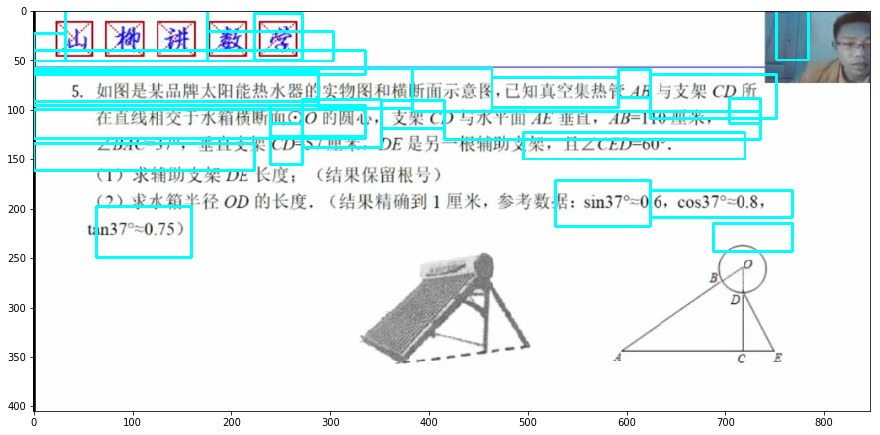

In [15]:
import lib.text_connector.text_proposal_connector as tpc
import lib.utils.nms as nms
import torch
import lib.layutils.proposal_layer as psl
import matplotlib.pyplot as plt
import cv2
import numpy as np
import importlib
importlib.reload(tpc)
importlib.reload(psl)
import time

DEBUG = False

def connect_proposal(text_proposals, scores, im_size):
    cp = tpc.TextProposalConnector()
    line = cp.get_text_lines(text_proposals, scores, im_size)
    return line


def save_results(image_name, image, line, thresh):
    im = image.copy()
    inds = np.where(line[:, -1] >= thresh)[0]
#     print('inds --->{}'.format(len(inds)))
    if len(inds) == 0:
        return
    
    for i in inds:
        bbox = line[i, :].astype(np.int)
#         print('bbox {}--> \n {}'.format(i,bbox))
        score = line[i, -1]
        cv2.rectangle(
            im, (bbox[0], bbox[1]), (bbox[6], bbox[7]),
            color=(0, 255, 255),
            thickness=2)
    plt.imshow(im,'brg')
    plt.show()
    cv2.imwrite('d:\\1.jpg',im)
    
def testConnectProposal():
    plt.rcParams['figure.figsize'] = 15, 10
    img = cv2.imread(roidb[2]['image'])
    boxes = roidb[2]['boxes']
    print(boxes)
    scores = np.ones(boxes.shape[0])
    CONF_THRESH = 0.9
    NMS_THRESH = 0.3
    print(boxes.shape)
    print(scores.shape)
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32)
    keep = nms.nms(dets, NMS_THRESH)
    dets = dets[keep,:]
    print(dets)
    line = connect_proposal(dets[:, 0:4], dets[:, 4], img.shape)
    line = line.astype(int)
    print(line)
    save_results("newimg.jpg", img, line, thresh=0.7)

def validNet(image_s,im_info):
    feat_stride = [16, ]
    ANCHOR_SCALES = [16]
    ANCHOR_RATIOS = [0.5,1,2]
    num_anchors = 10

#     blobs = data_layer.forward()
#     image = blobs['data']
#     image_src = image.copy()
#     im_info = blobs['im_info']
    image = image_s.copy()
    image = torch.from_numpy(image.transpose([0,3,1,2]))
    print('image shape --> {}'.format(image.size()))
    
    net.eval()
    net_conv = net._layers['head'](image)
    anchors, length = generate_anchors_pre(net_conv.size(2), net_conv.size(3),feat_stride=feat_stride,anchor_scales=(16,))
    anchors = torch.from_numpy(anchors)
    rpn = F.relu(net.rpn_net(net_conv))  # ( N , C, H, W）
    rpn_reshape = rpn.permute(0,2,3,1).squeeze(0)
    rpn_blstm,_ = net.rpn_bi_net(rpn_reshape)
    rpn_blstm = F.relu(rpn_blstm)  # 注意另外可以考虑采用batch normal方法对数据进行整理
    rpn_blstm_reshape = rpn_blstm.view(-1, RPN_CHANNELS)
    rpn_cls_score = net.rpn_cls_score_net(rpn_blstm)   # [W H, num_anchors*2], num_anchors = 10
    rpn_cls_score = rpn_cls_score.view(rpn_blstm.size()[0], rpn_blstm.size()[1],-1)
    rpn_cls_score = rpn_cls_score.permute(2,0,1).unsqueeze(0)
    rpn_cls_score = rpn_cls_score.permute(0,2,3,1)
    rpn_cls_score_reshape = rpn_cls_score.contiguous().view(1,rpn_cls_score.size()[1],-1,2)  
    # 得到坐标点的10个分类概率（二分类方法)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape.view(-1,2),dim=1)           # N 2 H*NUM_ANCHORS W
    rpn_cls_prob = rpn_cls_prob_reshape.view(rpn_cls_score.size()[0],
                                             rpn_cls_score.size()[1],
                                             -1,
                                             2 * num_anchors
                                            )
    
    if DEBUG:
        print('rpn_cls_score_reshape --> \n {}'.format(rpn_cls_score_reshape.size()) )
        print('rpn cls prob reshape --> \n {}'.format(rpn_cls_prob_reshape.size()))
        print('rpn_cls_score size {} --> \n {}'.format(rpn_cls_score.size(),rpn_cls_score))
        print('rpn_cls_prob size {} --> \n {}'.format(rpn_cls_prob.size(),rpn_cls_prob))
    
    rpn_bbox_pred  = net.rpn_bbox_pred_net(rpn_blstm_reshape)   # [W H, num_anchors*4], num_anchors = 10
    rpn_bbox_pred = rpn_bbox_pred.view(rpn_blstm.size()[0],rpn_blstm.size()[1],-1)
    rpn_bbox_pred = rpn_bbox_pred.unsqueeze(0)

    
    blob, scores = psl.proposal_layer(rpn_cls_prob, 
                                      rpn_bbox_pred.contiguous(),
                                      im_info,
                                      'TEST',
                                      feat_stride,
                                      anchors,
                                      num_anchors)
    return image_s, blob, scores, rpn_cls_prob, rpn_bbox_pred, rpn_cls_score,rpn_cls_prob_reshape

def showValidNet(image,im_info):
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
    image_orig = image.copy()
    image = image.astype(np.float32)
    image -= PIXEL_MEANS
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    start_time = time.time()
    with torch.no_grad():
        image_src, blob, scores , rpn_cls_prob, rpn_bbox_pred, rpn_cls_score,rpn_cls_prob_reshape = validNet(image,im_info)
    print('handle times {:.4f}'.format((time.time() - start_time)))  
    plt.rcParams['figure.figsize'] = 15, 10
    boxes = blob.data.numpy()[:,1:5]
    boxes = boxes.astype(np.int)
    score = scores.data.numpy()
    score = score.reshape(score.shape[0])
    image_new = image_src.reshape(image_src.shape[1],image_src.shape[2], image_src.shape[3])

    dets = np.hstack((boxes, score[:, np.newaxis])).astype(np.float32)
#     print('dets --> \n {}'.format(dets))
    keep = nms.nms(dets, 0.3)
    dets = dets[keep,:]
    
    line = connect_proposal(dets[:, 0:4], dets[:, 4], image_new.shape)
#     line = line.astype(int)
#     print(line)
    # image_new = image_src.reshape(image_src.shape[1],image_src.shape[2], image_src.shape[3])
    print(line[0:1])
    save_results('newimg.jpg',image_orig, line, 0.6)    
    return rpn_cls_prob, rpn_bbox_pred, rpn_cls_score,rpn_cls_prob_reshape,boxes,score, line,dets,image_new

# img_path = '/home/hecong/temp/data/txtdect/img/2.jpg'
img_path = 'd:\\cc_9.jpg'
image = cv2.imread(img_path,cv2.IMREAD_COLOR)
im_info = [image.shape[0],image.shape[1],1]

rpn_cls_prob, rpn_bbox_pred, rpn_cls_score,rpn_cls_prob_reshape,boxes,score, line,dets,image_new  =  showValidNet(image,im_info)

# testConnectProposal()
# showValidNet(image,im_info)


In [130]:
PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
image = cv2.imread('d:\\2.jpg',cv2.IMREAD_COLOR)
image = image.astype(np.float32)
image -= PIXEL_MEANS
image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
print(image.shape)

(1, 600, 878, 3)
